# Домашнее задание

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('../../data/retail_train.csv')
item_features = pd.read_csv('../../data/product.csv')
user_features = pd.read_csv('../../data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

D:\AnalystBigData\4_3 Recommendation System\6Урок\webinar_6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [11]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [12]:
%%time
recommender = MainRecommender(data_train_matcher)


Wall time: 3.99 s


# Eval recall of matching

## **Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
def evalRecall(df_result, result_col_name, recommend_model, N):
    target_col_name = 'actual'
    df_result[result_col_name] = df_result['user_id'].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[target_col_name], k=N), axis=1).mean()

In [15]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
%%time
N_PREDICT = [20, 50, 100, 200, 500]
models = {'own_rec': recommender.get_own_recommendations,
          'similar_items': recommender.get_similar_items_recommendation,
          'als_rec': recommender.get_als_recommendations}
results = {'own_rec': [],
           'similar_items': [],
           'als_rec': []}
for n in N_PREDICT:
    for model in models.keys():
        results[model].append(evalRecall(result_eval_matcher, model, models[model], n))

Wall time: 4min 42s


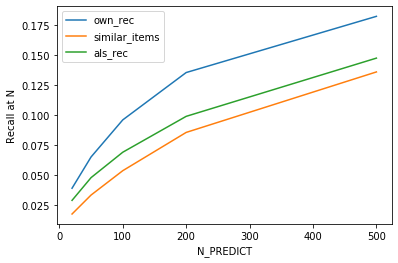

In [17]:
plt.plot(N_PREDICT, results['own_rec'])
plt.plot(N_PREDICT, results['similar_items'])
plt.plot(N_PREDICT, results['als_rec'])

plt.xlabel("N_PREDICT")
plt.ylabel("Recall at N")
plt.legend(labels=["own_rec", "similar_items", "als_rec"])
plt.show()

A) own recommendtions + top-popular действительно дает луший результат

В) Как видим из графика значение recall увеличивается при увеличении значения k. При чем качество увеличивается примерно пропорционально по всем способам предсказаний. После к=200 видно, что графики идут параллельно.

С) Так как они увеличиваются пропорционально, то нет большого смысла стремиться к большим значениям к. Если повзволяют возможности кластера, то я бы остановился на значении К=200.

In [18]:
# N = Neighbors
N_PREDICT = 50 

In [19]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 45 s


In [20]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 0 ns


In [21]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [22]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [23]:
TOPK_RECALL = 50

In [24]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04808877438364821),
 ('similar_items', 0.0336254552700734),
 ('sim_item_rec', 0.0336254552700734)]

### Precision@5 of matching

In [25]:
TOPK_PRECISION = 5

In [26]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.11678289167828829),
 ('similar_items', 0.060529986052998995),
 ('sim_item_rec', 0.060529986052998995)]

# Ranking part

## Подготовка данных для трейна

In [27]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [28]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [29]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [30]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [31]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [32]:
df_ranker_train.target.value_counts()

0.0    99669
1.0    11644
Name: target, dtype: int64

In [33]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


## Подготавливаем фичи для обучения модели

In [34]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [35]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

## **Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

#### Фичи user_id:
Cредний чек

In [36]:
data_train_matcher['cost'] = data_train_matcher['quantity'] *  data_train_matcher['price']

user_avg_receipt = data_train_matcher.groupby(['user_id', 'basket_id'])[['cost']].mean().reset_index().groupby('user_id')['cost'].mean()
user_avg_receipt.name = 'user_avg_receipt'
user_avg_receipt[:3]

user_id
1    3.572775
2    4.334782
3    4.858051
Name: user_avg_receipt, dtype: float64

Частота покупок раз в месяц

In [37]:
data_train_matcher['month'] = data_train_matcher['day'].apply(lambda x: (x+30)//30)

user_life_cycle = data_train_matcher.groupby(['user_id']).agg({ 'month': ['min', 'max'] }).reset_index()

user_life_cycle['life_cycle_month'] = user_life_cycle['month','max'] - user_life_cycle['month','min']
user_life_cycle.drop([('month','min'), ('month','max')], axis=1, inplace=True)
user_life_cycle.set_index('user_id',inplace = True)

frq_pur_month = data_train_matcher.groupby(['user_id'])['basket_id'].count() / user_life_cycle['life_cycle_month']
frq_pur_month.name = 'frq_pur_month'
frq_pur_month[:3]

user_id
1    36.722222
2    19.562500
3    15.937500
Name: frq_pur_month, dtype: float64

#### Фичи item_id
Среднее кол-во покупок в неделю

In [38]:
avg_purch_week = data_train_matcher.groupby(['item_id'])['quantity'].sum() / data_train_matcher['week_no'].max() 
avg_purch_week.name = 'avg_purch_week'
avg_purch_week[:4]

item_id
117847    0.576471
818981    0.905882
819255    2.776471
819308    3.682353
Name: avg_purch_week, dtype: float64

Среднее ол-во покупок 1 товара в категории в неделю

In [39]:
merge_df = pd.merge(data_train_matcher, item_features, how='inner', on='item_id')

pusrch_depart = merge_df.groupby(['department'])['quantity'].sum()
pusrch_item_depart = merge_df.groupby(['department','item_id'])['quantity'].sum().reset_index()


purchases_dep = pd.merge(pusrch_item_depart, pusrch_depart, on='department')
purchases_dep['avg_sales_group_week'] = purchases_dep['quantity_x'] / purchases_dep['quantity_y'] / data_train_matcher['week_no'].max()
purchases_dep.set_index('item_id', inplace=True)
avg_sales_group_week = purchases_dep['avg_sales_group_week']
avg_sales_group_week[:3]

item_id
1101805    0.011765
819978     0.000208
823862     0.000067
Name: avg_sales_group_week, dtype: float64

(Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)

In [40]:
metrik1 = avg_purch_week / avg_sales_group_week
metrik1.name = 'metrik1'
metrik1[:3]

item_id
117847      5816.0
818981    382803.0
819255     64712.0
Name: metrik1, dtype: float64

### Добавляем соотвветствующие фичи в таблицы

In [41]:
item_features = item_features.merge(avg_purch_week, how='left', on='item_id')

item_features = item_features.merge(avg_sales_group_week, how='left', on='item_id')

item_features = item_features.merge(metrik1, how='left', on='item_id')
item_features[~item_features['avg_sales_group_week'].isna()].head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_purch_week,avg_sales_group_week,metrik1
2315,117847,450,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ,0.576471,0.000099,5816.0
5809,818981,194,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ,0.905882,0.000002,382803.0
5830,819255,1007,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - PORK,1 LB,2.776471,0.000043,64712.0


In [42]:
user_features = user_features.merge(user_avg_receipt, how='left', on='user_id')

user_features = user_features.merge(frq_pur_month, how='left', on='user_id')
user_features.head(3) 

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,user_avg_receipt,frq_pur_month
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3.572775,36.722222
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,4.707806,20.263158
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,5.066071,35.411765


In [43]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_purch_week,...,metrik1,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_avg_receipt,frq_pur_month
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.223529,...,33404.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,0.623529,...,382803.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0


In [44]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

cat_feats = ['manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'age_desc',
       'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc',
       'household_size_desc', 'kid_category_desc']

X_train[cat_feats] = X_train[cat_feats].astype('category')

## Обучение модели ранжирования

In [45]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Progs\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Progs\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Progs\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


## Подготавливаем test dataset

In [46]:
df_ranker_val = data_val_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_val = df_match_candidates.merge(df_ranker_val, on=[USER_COL, ITEM_COL], how='left')

df_ranker_val = df_ranker_val.merge(item_features, on='item_id', how='left')
df_ranker_val = df_ranker_val.merge(user_features, on='user_id', how='left')

cat_feats = ['manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'age_desc',
       'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc',
       'household_size_desc', 'kid_category_desc']
df_ranker_val[cat_feats] = df_ranker_val[cat_feats].astype('category')

df_ranker_val.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_purch_week,avg_sales_group_week,metrik1,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_avg_receipt,frq_pur_month
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.223529,0.000037,33404.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,0.623529,0.000002,382803.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0
2,2070,879194,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.635294,0.000017,37084.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0
3,2070,948640,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.576471,0.000016,37084.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0
4,2070,928263,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.564706,0.000015,37084.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0


# Evaluation on test dataset

In [47]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [48]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 12.8 s


In [49]:
val_preds = lgb.predict_proba(df_ranker_val)
df_ranker_val_pred = df_ranker_val.copy()
df_ranker_val_pred['proba_item_purchase'] = val_preds[:,1]
df_ranker_val_pred.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_purch_week,avg_sales_group_week,...,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_avg_receipt,frq_pur_month,proba_item_purchase
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.223529,0.000037,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0,0.041974
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,0.623529,0.000002,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0,0.025497
2,2070,879194,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,0.635294,0.000017,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0,0.045651
3,2070,948640,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,0.576471,0.000016,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0,0.001594
4,2070,928263,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,0.564706,0.000015,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.656991,37.0,0.339318


## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [50]:
def rerank_val(user_id):
    return df_ranker_val_pred[df_ranker_val_pred[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [51]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank_val(user_id))

In [52]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15300261096605594)
('own_rec', 0.1444117647058813)


D:\AnalystBigData\4_3 Recommendation System\6Урок\webinar_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


In [53]:
sorted(calc_recall(result_eval_ranker, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.062389919263785204), ('reranked_own_rec', 0.01679870555719281)]